In [1]:
import os
import sys
import shutil
import glob
import random
import cv2
import matplotlib.pyplot as plt
import mlflow
from ultralytics import YOLO
from mlflow.tracking import MlflowClient
%matplotlib inline 
# 1. CONFIGURACIÓN DE RUTAS
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

# Rutas de datos y modelos
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, "data", "processed_dataset")
FEEDBACK_DATA_DIR = os.path.join(BASE_DIR, "data", "feedback_dataset")
MODELS_DIR = os.path.join(BASE_DIR, "models")
MODELS_HISTORY = os.path.join(BASE_DIR, "models_history")
MLFLOW_DB = os.path.join(BASE_DIR, "mlflow.db")

# Configurar MLflow
db_uri = f"sqlite:///{MLFLOW_DB.replace(os.sep, '/')}"
mlflow.set_tracking_uri(db_uri)
mlflow.set_experiment("Furniture_Detection_System")

c:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026/02/03 03:22:05 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/03 03:22:05 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/03 03:22:05 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/03 03:22:05 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/03 03:22:05 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/03 03:22:05 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/03 03:22:06 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/03 03:22:06 INFO alembic.runtime.migratio

<Experiment: artifact_location=('file:///c:/Users/andre/OneDrive/Documents/UPS/Inteligencia '
 'Artificial/YOLOv8_living-room_furniture/mlruns'), creation_time=1770106818785, experiment_id='1', last_update_time=1770106818785, lifecycle_stage='active', name='Furniture_Detection_System', tags={}>

## Prueba con imagen del dataset

Cargando modelo: best.pt

image 1/1 c:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\processed_dataset\valid\images\0599f04f117af81bcc30710b96ad6a3b_jpg.rf.c7c71123859f7f53f5bf0632ca52e881.jpg: 640x640 (no detections), 9.4ms
Speed: 20.2ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


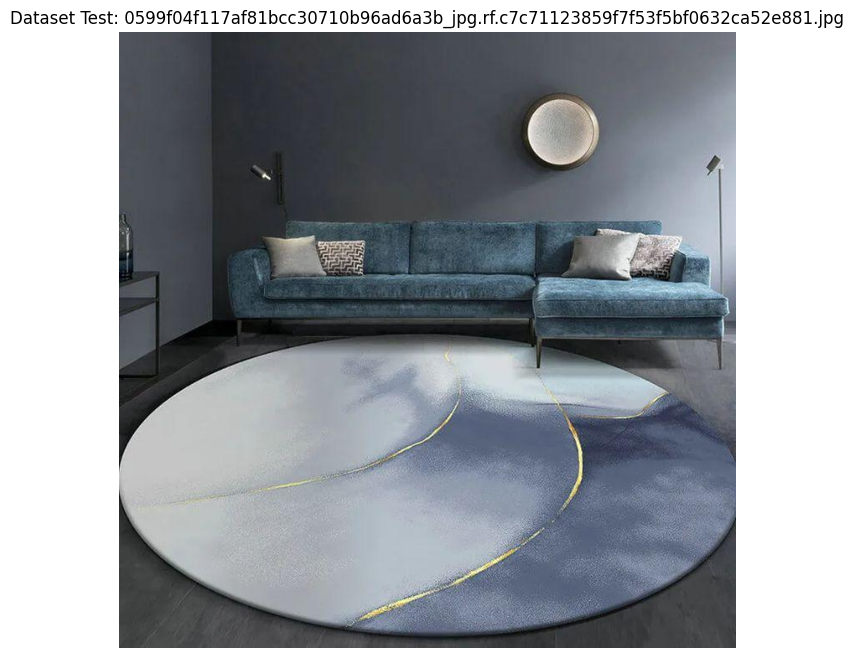

In [2]:
def predict_random_dataset_image():
    # Cargar el modelo base
    model_path = os.path.join(MODELS_DIR, "best.pt")
    
    if not os.path.exists(model_path):
        print(f" No se encontró el modelo en {model_path}.")
        return
    print(f"Cargando modelo: {os.path.basename(model_path)}")
    model = YOLO(model_path)
    # Buscar imágenes en Test o Valid
    search_path = os.path.join(PROCESSED_DATA_DIR, "valid", "images", "*")
    images_list = glob.glob(search_path)
    if not images_list:
        print(" No hay imágenes para probar.")
        return

    # Predicción
    selected_img = random.choice(images_list)
    results = model.predict(selected_img, conf=0.25)

    # Visualización
    result_plot = results[0].plot()
    result_rgb = cv2.cvtColor(result_plot, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(result_rgb)
    plt.axis('off')
    plt.title(f"Dataset Test: {os.path.basename(selected_img)}")
    plt.show()

predict_random_dataset_image()

## Prueba con imagen externa

Para simular datos nuevos, se usarán imágenes de la carpeta 'valid'.

### Trasladar imágenes y labels de valid a feedback

In [3]:
def prepare_simulation_data(num_samples=25):
    # Rutas origen y destino 
    SRC_IMG_DIR = os.path.join(PROCESSED_DATA_DIR, "valid", "images")
    SRC_LBL_DIR = os.path.join(PROCESSED_DATA_DIR, "valid", "labels")
    
    DEST_IMG_DIR = os.path.join(FEEDBACK_DATA_DIR, "images")
    DEST_LBL_DIR = os.path.join(FEEDBACK_DATA_DIR, "labels")
    
    # Limpiar feedback previo
    if os.path.exists(DEST_IMG_DIR): shutil.rmtree(DEST_IMG_DIR)
    if os.path.exists(DEST_LBL_DIR): shutil.rmtree(DEST_LBL_DIR)
    os.makedirs(DEST_IMG_DIR, exist_ok=True)
    os.makedirs(DEST_LBL_DIR, exist_ok=True)
    
    # Seleccionar imágenes al azar
    candidates = glob.glob(os.path.join(SRC_IMG_DIR, "*.jpg"))
    selected = random.sample(candidates, min(len(candidates), num_samples))
    
    count = 0
    for img_path in selected:
        basename = os.path.basename(img_path)
        txt_name = os.path.splitext(basename)[0] + ".txt"
        src_txt = os.path.join(SRC_LBL_DIR, txt_name)
        
        if os.path.exists(src_txt):
            shutil.copy(img_path, os.path.join(DEST_IMG_DIR, basename))
            shutil.copy(src_txt, os.path.join(DEST_LBL_DIR, txt_name))
            count += 1
            
    print(f" Se copiaron {count} imágenes nuevas a 'data/feedback_dataset'.")

prepare_simulation_data(num_samples=30)

 Se copiaron 30 imágenes nuevas a 'data/feedback_dataset'.


### Predicción


image 1/1 c:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\feedback_dataset\images\Image-52_jpg.rf.2e6e6ecef889df4889dbdaea0c9e458c.jpg: 480x640 (no detections), 31.1ms
Speed: 6.8ms preprocess, 31.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


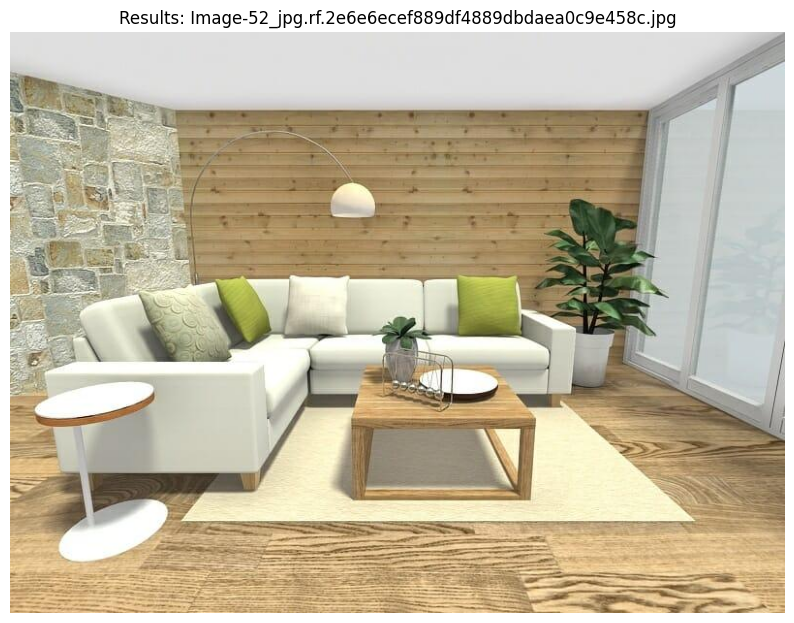

In [62]:
def predict_feedback_before_retrain():
    
    feedback_imgs = glob.glob(os.path.join(FEEDBACK_DATA_DIR, "images", "*"))
    if not feedback_imgs:
        print("No hay imágenes de feedback.")
        return
    # Cargar modelo actual
    model = YOLO(os.path.join(MODELS_DIR, "best.pt"))
    # Seleccionar una
    selected_img = random.choice(feedback_imgs)
    results = model.predict(selected_img, conf=0.25)
    
    result_plot = results[0].plot()
    result_rgb = cv2.cvtColor(result_plot, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(result_rgb)
    plt.axis('off')
    plt.title(f"Results: {os.path.basename(selected_img)}")
    plt.show()

predict_feedback_before_retrain()

### Simulación de Re-train

In [3]:
import os

try:
    from app.retrain_service import execute_retraining_cycle
    print("Servicio 'app.retrain_service' importado correctamente.")
except ImportError as e:
    print(f"Error importando la App: {e}")

def run_production_retrain_demo():
    model_path = os.path.join(MODELS_DIR, "best.pt")
    
    if not os.path.exists(model_path):
        print("No se encontró el modelo base 'best.pt'. ¿Ejecutaste el sabotaje en el NB 02?")
        return
    CANTIDAD_FOTOS_RETRAIN = 50 
    print("⏳ Iniciando proceso de reentrenamiento...")
    try:
        run_id = execute_retraining_cycle(model_path, data_limit=CANTIDAD_FOTOS_RETRAIN)
        
        if run_id:
            print(f"\nModelo reentrenado con éxito.")
            print(f"MLflow Run ID: {run_id}")
        else:
            print("\nEl servicio finalizó pero no generó un Run ID.")
            
    except Exception as e:
        print(f"\nError en ejecución: {e}")

run_production_retrain_demo()

Servicio 'app.retrain_service' importado correctamente.
⏳ Iniciando proceso de reentrenamiento...
New https://pypi.org/project/ultralytics/8.4.10 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.8  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\yolo_retrain_work\mixed_training.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=2, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgs

2026/02/03 03:23:36 INFO mlflow.tracking.fluent: Experiment with name 'c:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\yolo_retrain_work' does not exist. Creating a new experiment.


MLflow: logging run_id(8864e19ac63845e88052295329da5cd7) to sqlite:///c:/Users/andre/OneDrive/Documents/UPS/Inteligencia Artificial/YOLOv8_living-room_furniture/mlflow.db
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\yolo_retrain_work\retrain_run
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/2      1.07G      1.224      1.865      1.299         57        640: 100% ━━━━━━━━━━━━ 25/25 3.0it/s 8.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 5.5it/s 1.8s.2s
                   all        149        735      0.909      0.397      0.656      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        2/2      1.24G      1.113      1.424 

### Reintentar predicción

Analizando: Image-52_jpg.rf.2e6e6ecef889df4889dbdaea0c9e458c.jpg

image 1/1 c:\Users\andre\OneDrive\Documents\UPS\Inteligencia Artificial\YOLOv8_living-room_furniture\data\feedback_dataset\images\Image-52_jpg.rf.2e6e6ecef889df4889dbdaea0c9e458c.jpg: 480x640 1 Rug, 136.3ms
Speed: 3.9ms preprocess, 136.3ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)


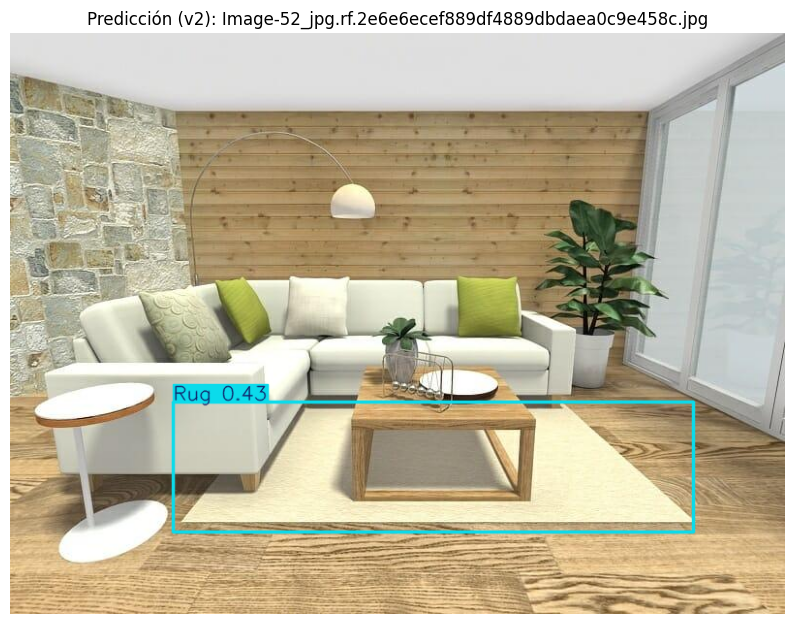

In [4]:
def verify_new_model():
    # 1. Definir el modelo a probar (best_v2.pt)
    model_path = os.path.join(MODELS_DIR, "best_v2.pt")
    if not os.path.exists(model_path):
        print("No se encontró 'best_v2.pt'")
        return
    
    model = YOLO(model_path)
    
    # 2. Definir la imagen específica
    # Usamos FEEDBACK_DATA_DIR que definimos al inicio del notebook
    target_filename = "Image-52_jpg.rf.2e6e6ecef889df4889dbdaea0c9e458c.jpg"
    selected_img = os.path.join(FEEDBACK_DATA_DIR, "images", target_filename)
    
    # Verificación de existencia
    if not os.path.exists(selected_img):
        print(f"ERROR: No se encontró la imagen específica en:\n{selected_img}")
        return

    # 3. Predicción
    print(f"Analizando: {target_filename}")
    results = model.predict(selected_img, conf=0.25)
    
    # 4. Visualización
    result_plot = results[0].plot()
    result_rgb = cv2.cvtColor(result_plot, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(result_rgb)
    plt.title(f"Predicción (v2): {target_filename}")
    plt.axis('off')
    plt.show()

verify_new_model()

## Conclusiones

Gracias al sabojate al modelo base, el reentrenamiento fue capaz de mostrar resultados notorios, como se puede observar con la imágen puesta a prueba, donde el modelo pasó de no detectar nada a detectar una alfombra con 43% de confianza. Además, se observó que la métrica mAP50 elevó hasta 82%, esto representa un salto de gran magnitud en comparación al modelo base, por lo que concluimos que los parámetros de reentrenamiento deben pasar por una revisión para tener un aprendizaje más lento y suave.